# <center> Zero Shot Forecasting with Autogluon </center>

- LLM Approach
- Zero shot forecasting is a machine learning technique that allows models to make predictions on new time series data without prior training. This is possible because the models are pretrained on a large amount of data, which allows them to generalize across different types of time series data.

In [1]:
import sys 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [32]:
df = pd.read_csv('data/ohlcv.csv', parse_dates=['timestamp'], index_col='timestamp')
df = df.asfreq('B').bfill().ffill().reset_index()

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale Data
scaler = StandardScaler()
X = df.drop(columns=['timestamp', 'item_id'])
scaler.fit(X)
scaled_data = scaler.transform(X)

# Fit PCA on the scaled data to get a projection of the full dataset in 2D
pca = PCA(n_components=2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

# Use Kmeans Algorithm on the decomposed data to get labels. 
from sklearn.cluster import KMeans

# Create a KMeans model
kmeans = KMeans(n_clusters=2)
kmeans.fit(x_pca)

# Add the labels to the dataframe
df['item_id'] = kmeans.labels_

<Axes: title={'center': 'S&P 500 With Unsupervised Labels'}, xlabel='timestamp', ylabel='target'>

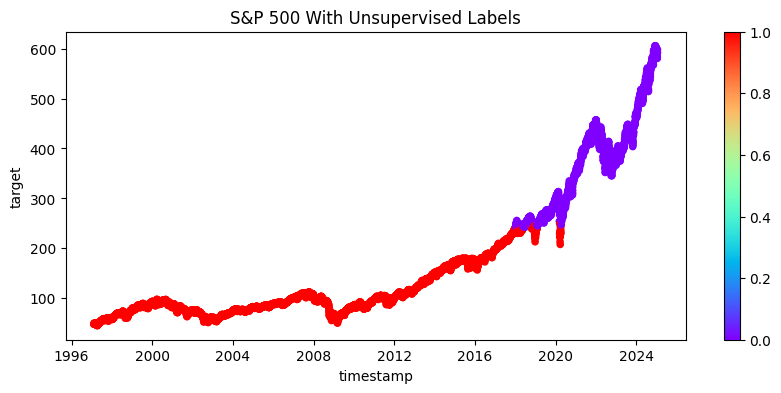

In [34]:
target = df[['item_id', 'timestamp', 'target']]
features = df.drop(columns = ['target', 'item_id', 'timestamp'])
target[['timestamp','target']].plot(x='timestamp', y='target', figsize=(10,4), kind = 'scatter', c = target['item_id'], cmap='rainbow', title = 'S&P 500 With Unsupervised Labels')

In [35]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
# df = TimeSeriesDataFrame("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly/train.csv")

In [36]:
# Set Forecast Horizion:
fh = 30

train = target.iloc[:-fh]
test = target.iloc[-fh:]

print(f'OG Shape: {target.shape}\tTraining data shape: {train.shape}\t Testing data shape: {test.shape}')

OG Shape: (7291, 3)	Training data shape: (7261, 3)	 Testing data shape: (30, 3)


In [40]:
df = TimeSeriesDataFrame(train)

# Define the predictor Model, This creates a model that is saved to the AutoGluon folder 
predictor = TimeSeriesPredictor(
    target = 'target',
    prediction_length=fh,
    freq = 'B', 
    eval_metric = 'MAPE', 
    log_to_file = False,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250117_221701"


In [41]:
# Fit the model to the training data 
predictor.fit(
    train_data = train, 
    presets = 'fast_training',
    hyperparameters={
        "Chronos": {"model_path": "autogluon/chronos-bolt-base", 'context_length': 200},
        "TemporalFusionTransformer": {"model_path": "autogluon/tft-base", 'context_length': 200},
        "AutoARIMA": {"model_path": "autogluon/arima-base"},
        },
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/jerald/Documents/Dir/Python/TimeSeriesModels/examples/AutogluonModels/ag-20250117_221701'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.2.0: Fri Dec  6 18:40:14 PST 2024; root:xnu-11215.61.5~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       4.22 GB / 16.00 GB (26.4%)
Disk Space Avail:   32.87 GB / 460.43 GB (7.1%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'B',
 'hyperparameters': {'AutoARIMA': {'model_path': 'autogluon/arima-base'},
                     'Chronos': {'context_length': 200,
                                 'model_path': 'autogluon/chronos-bolt-base'},
                     'TemporalFusionTransformer': {'context_length': 200,
                  

In [43]:
# Evaluate the results
predictor.evaluate(train)

data with frequency 'None' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MAPE': -0.029616644116045768}

In [44]:
predictions = predictor.predict(test)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
0       2025-01-20  595.189602  587.877712  590.497433  592.336318   
        2025-01-21  593.650686  583.479339  587.082923  589.622180   
        2025-01-22  590.807224  578.481219  582.825372  585.889367   
        2025-01-23  589.749754  576.504995  581.155818  584.441532   
        2025-01-24  589.571876  575.894686  580.682469  584.071890   
        2025-01-27  590.341265  576.426822  581.288883  584.740622   
        2025-01-28  591.179875  577.030502  581.962625  585.471316   
        2025-01-29  591.776272  577.302849  582.335861  585.924753   
        2025-01-30  591.920429  576.996937  582.174479  585.875862   
        2025-01-31  591.744408  576.292581  581.641983  585.476040   
        2025-02-03  591.521029  575.483623  580.988708  584.952369   
        2025-02-04  591.265709  574.740513  580.400541  584.486557   
        2025-02-05  591.145175  574.193226  579.988995  584.182161   
        2025-02-06  591.153753  573.820508  579.738312  584.027121   
        2025-02-07  591.230106  573.537672  579.571527  583.950437   
        2025-02-10  591.314487  573.249345  579.412622  583.890905   
        2025-02-11  591.355103  572.927499  579.211770  583.780378   
        2025-02-12  591.349410  572.555520  578.962715  583.622398   
        2025-02-13  591.313094  572.154370  578.684614  583.435011   
        2025-02-14  591.269084  571.752669  578.404069  583.243555   
        2025-02-17  591.238579  571.360904  578.142454  583.077871   
        2025-02-18  591.220300  571.003825  577.902127  582.921509   
        2025-02-19  591.214703  570.668769  577.680530  582.781465   
        2025-02-20  591.214566  570.346043  577.468926  582.649760   
        2025-02-21  591.213221  570.027059  577.259387  582.519066   
        2025-02-24  591.210194  569.699513  577.050512  582.396119   
        2025-02-25  591.199969  569.378124  576.837451  582.259772   
        2025-02-26  591.187051  569.059030  576.624588  582.122307   
        2025-02-27  591.173944  568.744922  576.414729  581.986617   
        2025-02-28  591.162337  568.437385  576.209540  581.854497   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
0       2025-01-20  593.814197  595.189602  596.555374  598.143898   
        2025-01-21  591.698174  593.650686  595.590643  597.781872   
        2025-01-22  588.416806  590.807224  593.188474  595.830076   
        2025-01-23  587.168975  589.749754  592.322807  595.149429   
        2025-01-24  586.898085  589.571876  592.236126  595.145845   
        2025-01-27  587.617656  590.341265  593.045716  595.999217   
        2025-01-28  588.404635  591.179875  593.932909  596.932577   
        2025-01-29  588.932497  591.776272  594.595270  597.661856   
        2025-01-30  588.983905  591.920429  594.830357  597.991927   
        2025-01-31  588.700270  591.744408  594.760817  598.034856   
        2025-02-03  588.326799  591.521029  594.660437  598.009659   
        2025-02-04  587.974034  591.265709  594.502258  597.957066   
        2025-02-05  587.769041  591.145175  594.467709  598.014394   
        2025-02-06  587.702758  591.153753  594.553501  598.182248   
        2025-02-07  587.708849  591.230106  594.702672  598.408690   
        2025-02-10  587.725990  591.314487  594.850306  598.636021   
        2025-02-11  587.697149  591.355103  594.964859  598.829155   
        2025-02-12  587.621033  591.349410  595.033849  598.977689   
        2025-02-13  587.514222  591.313094  595.071800  599.094955   
        2025-02-14  587.400710  591.269084  595.100379  599.201355   
        2025-02-17  587.304722  591.238579  595.131813  599.311499   
        2025-02-18  587.221459  591.220300  595.182603  599.436671   
        2025-02-19  587.152382  591.214703  595.244186  599.570701   
        2025-02-20  587.089716  591

In [45]:
ytrue = test[['timestamp', 'target']].set_index('timestamp').sort_index()
ytrain = train[['timestamp', 'target']].set_index('timestamp').sort_index().tail(100)
ypred = predictions.reset_index()[['timestamp', 'mean']].set_index('timestamp').sort_index().tail(fh)

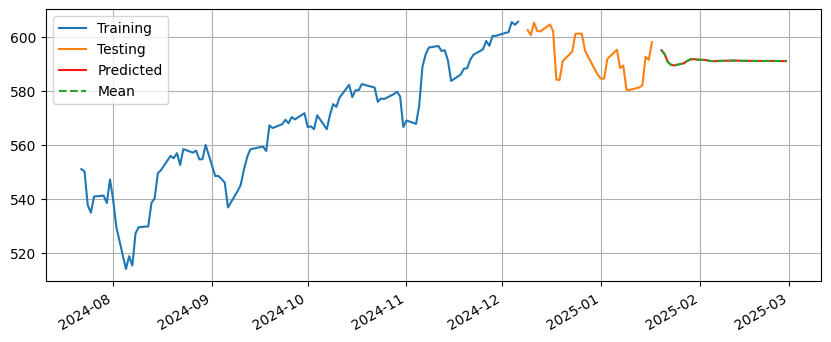

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ytrain, label='Training')
ax.plot(ytrue, label='Testing')
ax.plot(ypred, label='Predicted', alpha = 0.9, c = 'red')
ax.plot(ypred.groupby(ypred.index.date).mean(), label='Mean', linestyle='--')
ax.legend()
ax.grid()
fig.autofmt_xdate()

In [47]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.029617,3.118600,0.109392,4
1,AutoARIMA,-0.038027,3.097252,0.013630,1
2,TemporalFusionTransformer,-0.383102,0.021348,208.707236,3
3,Chronos[autogluon__chronos-bolt-base],-0.388955,1.941480,0.009955,2


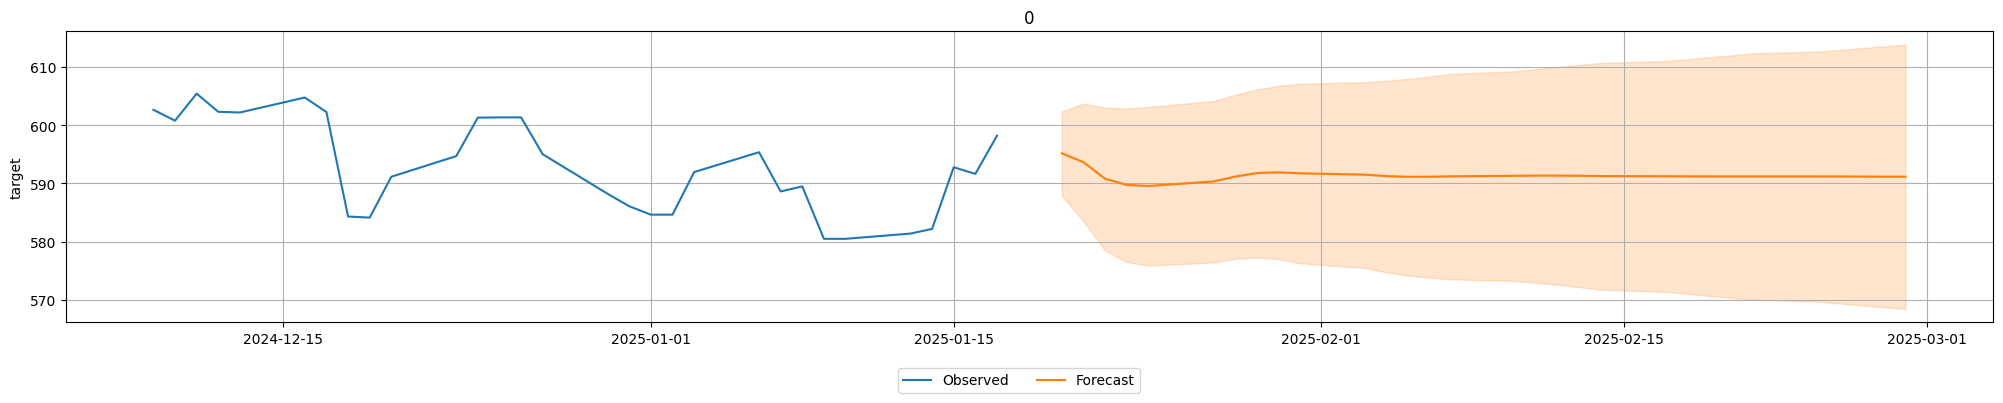

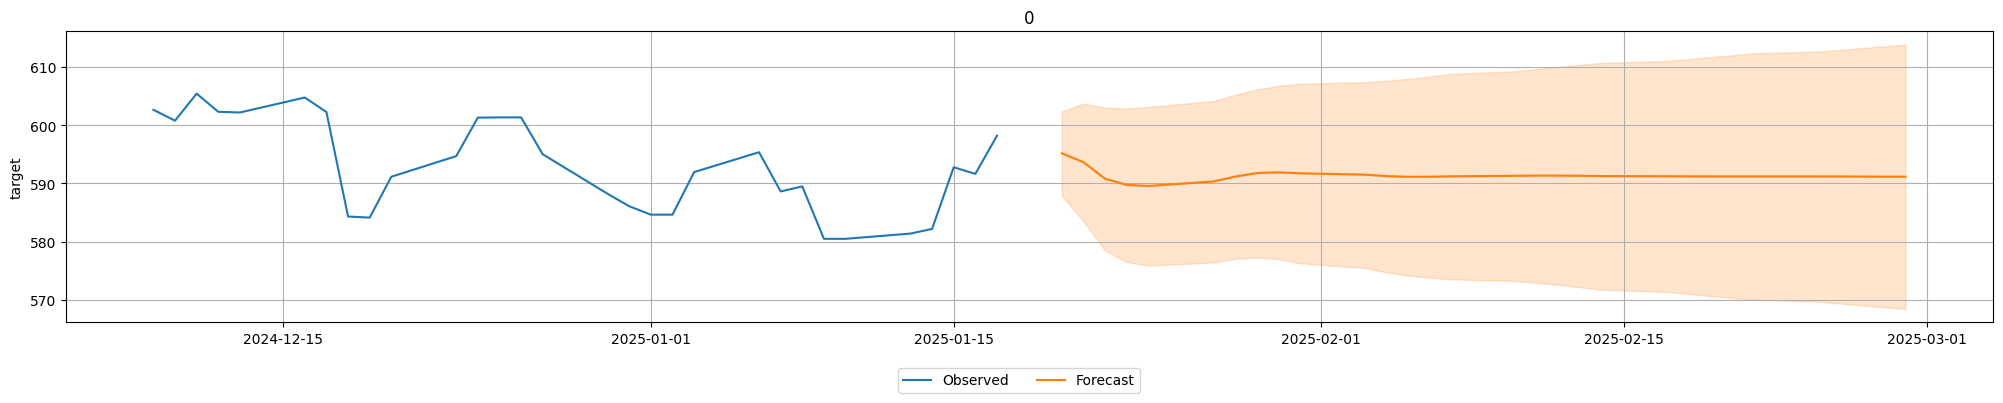

In [48]:
import matplotlib.pyplot as plt
predictor.plot(test, predictions=predictions, quantile_levels=[0.1, 0.9], max_history_length=100)

In [56]:
sys.path.append('../')
from correlation import analyze_correlation

data = pd.read_csv('data/ohlcv.csv', parse_dates=['timestamp'], index_col='timestamp')
data = data.asfreq('B').bfill().ffill()

In [59]:
x = data.drop(columns=['target'])
y = data['target']

acc = analyze_correlation(x, y)
acc.analyze()

/Users/jerald/Documents/Dir/Python/TimeSeriesModels/examples/../correlation.py:38: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df.index = df.index.to_period('B')


['Open', 'High', 'Low', 'Volume', 'item_id', 'target']


ValueError: 'target' is not in list

In [55]:
x

,Open,High,Low,Volume
0,48.312300,48.580489,47.680141,2321000.0
1,48.580544,48.752951,48.072900,1670000.0
2,48.293164,48.657135,47.890881,1664300.0
3,48.657150,49.432982,48.590103,2675400.0
4,49.538338,49.998090,49.461712,1104800.0
...,...,...,...,...
7286,575.770020,581.750000,575.349976,47910100.0
7287,584.359985,585.000000,578.349976,48420600.0
7288,590.330017,593.940002,589.200012,56900200.0
7289,594.169983,594.349976,590.929993,43265800.0
